# <font style="color:rgb(50,120,229)">Motivation </font>
Earlier, we have used Multilayer Perceptron for image classification on Fashion MNIST. We have achieved accuracy of 85% on test data. To improve the accuracy further if we choose to add more hidden layers, the number of parameters will grow high (N1xN2xN3..., N(ith layer) - number of nodes) and also leads to redundancy in learning. Another disadvantage of MLP is it doesn't learn spatial information. In Convolutional Neural Network, we can account for spatial information and also increase the number of layers where the weights are smaller and shared. This makes CNN easy to train than MLP for more number of layers. Now, lets see how CNN learns spatial information
compared to MLP.

Given below is an example of the first test image which corresponds to the `Boot` class. The image is shifted by some amount to the top and bottom. The classifier predicts it correctly for the centered image but fails in the other two cases. To make it work for these images, either we have to train separate MLPs for different locations or we have to make sure that we have all these variations in the training set as well, which I would say is difficult, if not impossible.

<img src="https://www.learnopencv.com/wp-content/uploads/2019/12/mlp-shift-failure.jpg" width="900">

The Fully connected network tries to learn global features or patterns. It acts as a good classifier.

Another major problem with a fully connected classifier is that the number of parameters increases very fast since each node in layer L is connected to a node in layer L-1. So it is not feasible to design very deep networks using an MLP structure alone.

Both the above problems are solved to a great extent by using Convolutional Neural Networks.

Here, we are going to implement CNN using libtorch.

## <font style="color:rgb(50,120,229)">Import Libraries </font>

Import required libraries and define constants like
- batchSize
- epoch
- logInterval
- Images path of train and test
- Labels path of train and test
- Torch device(it is specified to use GPU if available else CPU)

```cpp
#include <stdint.h>
#include <torch/torch.h>
#include <iostream>
#include <string>
#include <vector>
#include <opencv2/core/core.hpp>
#include <opencv2/opencv.hpp>
#include <opencv2/highgui/highgui.hpp>
#include "read-mnist.h"

struct Options {
  int batchSize = 256; //Batch size
  size_t epochs = 10; // Number of epochs
  size_t logInterval = 20;
  //Paths to train and test images and labels
  const char* trainImagesPath = "train-images-idx3-ubyte";
  const char* trainLabelsPath = "train-labels-idx1-ubyte";
  const char* testImagesPath = "t10k-images-idx3-ubyte";
  const char* testLabelsPath = "t10k-labels-idx1-ubyte";
  torch::DeviceType device = torch::kCPU;
};

static Options options;
```

# <font style="color:rgb(50,120,229)">1. Convolutional Neural network</font>
We will use Convolutional Neural Network of 3 convolutional blocks and 3 fully connected layers(including output). Convolutional block consists of 2 convolutional layers, 1 max pooling layer and then dropout to be added.

All the layers are defined with parameters and registered as modules. Then the network is implemented using these layers in order along with activation functions.

We need to apply log softmax on the output to get the probabilities of all the classes.

```cpp
struct Net: torch::nn::Module {
    Net() {
        //Convolutional layer 1: 32 filters, 3x3 Kernel size, padding=1
        //torch::nn::Conv2dOptions(input_channels, output_channels, kernel_size).padding(p).stride(s) and similarly other options
        conv1_1 = register_module("conv1_1", torch::nn::Conv2d(torch::nn::Conv2dOptions(1, 32, 3).padding(1)));
        //Convolutional layer 2: 32 filters, 3x3 Kernel size, padding=0
        conv1_2 = register_module("conv1_2", torch::nn::Conv2d(torch::nn::Conv2dOptions(32, 32, 3)));
        // Insert pool layer (poolsize-[2,2])
        dp1 = register_module("dp1", torch::nn::Dropout(0.25));

        //Convolutional layer 3: 64 filters, 3x3 Kernel size, padding=1
        conv2_1 = register_module("conv2_1", torch::nn::Conv2d(torch::nn::Conv2dOptions(32, 64, 3).padding(1)));
        //Convolutional layer 4: 64 filters, 3x3 Kernel size, padding=0
        conv2_2 = register_module("conv2_2", torch::nn::Conv2d(torch::nn::Conv2dOptions(64, 64, 3)));
        // Insert pool layer (poolsize-[2,2])
        dp2 = register_module("dp2", torch::nn::Dropout(0.25));

        //Convolutional layer 5: 64 filters, 3x3 Kernel size, padding=1
        conv3_1 = register_module("conv3_1", torch::nn::Conv2d(torch::nn::Conv2dOptions(64, 64, 3).padding(1)));
        //Convolutional layer 6: 32 filters, 3x3 Kernel size, padding=0
        conv3_2 = register_module("conv3_2", torch::nn::Conv2d(torch::nn::Conv2dOptions(64, 64, 3)));
        // Insert pool layer (poolsize-[2,2])
        dp3 = register_module("dp3", torch::nn::Dropout(0.25));
        
        //Fully connected layer - torch::nn:Linear(input_size, output_size(number of neurons))
        fc1 = register_module("fc1", torch::nn::Linear(64, 512));
        fc2 = register_module("fc2", torch::nn::Linear(512, 512));
        fc3 = register_module("fc3", torch::nn::Linear(512, 10));
    }

    // Implement Algorithm
    torch::Tensor forward(torch::Tensor x) {
        x = torch::relu(conv1_1->forward(x));
        x = torch::relu(conv1_2->forward(x));
        x = torch::max_pool2d(x, 2);
        x = dp1(x);

        x = torch::relu(conv2_1->forward(x));
        x = torch::relu(conv2_2->forward(x));
        x = torch::max_pool2d(x, 2);
        x = dp2(x);

        x = torch::relu(conv3_1->forward(x));
        x = torch::relu(conv3_2->forward(x));
        x = torch::max_pool2d(x, 2);
        x = dp3(x);

        x = x.view({-1, 64});

        x = torch::relu(fc1->forward(x));
        x = torch::relu(fc2->forward(x));
        x = fc3->forward(x);

        return torch::log_softmax(x, 1);
    }

    // Declare layers
    torch::nn::Conv2d conv1_1{nullptr};
    torch::nn::Conv2d conv1_2{nullptr};
    torch::nn::Conv2d conv2_1{nullptr};
    torch::nn::Conv2d conv2_2{nullptr};
    torch::nn::Conv2d conv3_1{nullptr};
    torch::nn::Conv2d conv3_2{nullptr};
    torch::nn::Dropout dp1{nullptr}, dp2{nullptr}, dp3{nullptr};

    torch::nn::Linear fc1{nullptr}, fc2{nullptr}, fc3{nullptr};
};
```

# <font style="color:rgb(50,120,229)">2. Load the Data</font>
In libtorch, Fashion MNIST is not a built-in dataset so we need to custom load the data. This dataset is available in ubyte(eg:train-images-idx3-ubyte) format files. This format files are explained here - http://yann.lecun.com/exdb/mnist/.

We have 2 different files for images and labels in case of both train and test data. We will use Custom Dataset Class like we did for linear regression earlier to process the data and convert to tensor form. Normalization of images is also performed in read-mnist.h after tensor conversion. 

```cpp
//Read images from ubyte format and convert to tensors
torch::Tensor process_images(const std::string& root, bool train) {
  const auto path = root + (train ? options.trainImagesPath: options.testImagesPath); //images_path
  auto images = read_mnist_images(path);

  return images;
}

//Read labels from ubyte format and convert to tensors
torch::Tensor process_labels(const std::string& root, bool train) {
  const auto path = root + (train ? options.trainLabelsPath: options.testLabelsPath); //labels_path
  auto labels = read_mnist_labels(path);

  return labels;
}


//Use CustomDataset class to load any type of dataset other than inbuilt datasets
class CustomDataset : public torch::data::datasets::Dataset<CustomDataset> {
    private:
    // data should be 2 tensors
        torch::Tensor images, labels;
        size_t img_size;
    public:
        CustomDataset(const std::string& root, bool train) {
            images = process_images(root, train);
            labels = process_labels(root, train);
            img_size = images.size(0);
        }

        //Returns the data sample at the given `index
        torch::data::Example<> get(size_t index) override {
            // This should return {torch::Tensor, torch::Tensor}
            torch::Tensor img = images[index];
            torch::Tensor label = labels[index];
            return {img.clone(), label.clone()};
        };
    
    torch::optional<size_t> size() const override {
        return img_size;
    };
};
```

# <font style="color:rgb(50,120,229)">3. Train the Model</font>
Training data is passed in set of batches and **negative log likelihood** loss function is used to calculate the loss. Then the loss function is passed through **Adam** optimizer which is defined in the main().

Following are the major functions of training the network
- Initialize the network in training mode
        
        network->train()
- Uses negative log likelihood loss
        
        torch::nll_loss(output, targets)
- Computes the gradients in the network
        
        loss.backward()
- Updates the parameters of the network using the computed gradients
        
        optimizer.step()

```cpp
template <typename DataLoader>
void train(std::shared_ptr<Net> network, DataLoader& loader, torch::optim::Optimizer& optimizer, size_t epoch, size_t data_size) {
  size_t index = 0;
  //Set network in the training mode
  network->train();
  float Loss = 0, Acc = 0;

  for (auto& batch : loader) {
    auto data = batch.data.to(options.device);
    auto targets = batch.target.to(options.device).view({-1});
    // Execute the model on the input data
    auto output = network->forward(data);

    //Using mean square error loss function to compute loss
    auto loss = torch::nll_loss(output, targets);
    auto acc = output.argmax(1).eq(targets).sum();

    // Reset gradients
    optimizer.zero_grad();
    // Compute gradients
    loss.backward();
    //Update the parameters
    optimizer.step();

    Loss += loss.template item<float>();
    Acc += acc.template item<float>();
  }

  if (index++ % options.logInterval == 0) {
    auto end = data_size;

    std::cout << "Train Epoch: " << epoch << " " << end << "/" << data_size
              << "\tLoss: " << Loss / end << "\tAcc: " << Acc / end
              << std::endl;
  }
};
```

# <font style="color:rgb(50,120,229)">4. Test the Model</font>
Similar to the above, the test data is passed through the trained network. Loss is calculated on test data at each epoch. After all epochs, 3 sample outputs and their ground truth are displayed.

Following are the major functions of test the network
- Initialize the network in testing mode
      
      network->eval()
- Compute negative log likelihood loss
    
      torch::nll_loss(output, targets)

```cpp
void test(std::shared_ptr<Net> network, DataLoader& loader, size_t epoch, size_t data_size) {
  network->eval();
  size_t index = 0;
  float Loss = 0, Acc = 0;
  int display_count = 0;

  for (const auto& batch : loader) {
    auto data = batch.data.to(options.device);
    auto targets = batch.target.to(options.device).view({-1});

    auto output = network->forward(data);

    //To display 3 test image and its output
    if (display_count < 3 && epoch== options.epochs) {
      cv::Mat test_image(28,28,CV_8UC1);
      torch::Tensor tensor = data[display_count].mul_(255).clamp(0,255).to(torch::kU8);
      tensor = tensor.to(torch::kCPU);
      std::memcpy((void*)test_image.data,tensor.data_ptr(),sizeof(torch::kU8)*tensor.numel());

      std::cout << "***** TESTING on TEST IMAGE " << display_count << " *****" << std::endl;
      std::cout << "GroundTruth: " << targets[display_count].template item<float>()
                << ", Prediction: " << output[display_count].argmax() << std::endl;
      std::cout << "Output Probabilities" << std::endl;
      for (int i =0; i < output[display_count].size(0); i++) {
        std::cout << "Class: " << i << " " << torch::exp(output[display_count])[i].template item<float>()  << std::endl;
      }
      cv::imwrite("OUTPUT_GT_" + std::to_string(targets[display_count].template item<int>()) +
                  "_Pred_" + std::to_string(output[display_count].argmax().template item<int>()) + ".jpg", test_image);
      std::cout << "Outputs saved, Please checkout the output images" << std::endl;

      display_count++;
    }

    auto loss = torch::nll_loss(output, targets);
    auto acc = output.argmax(1).eq(targets).sum();

    Loss += loss.template item<float>();
    Acc += acc.template item<float>();
  }

  //This block can be used inside for loop to see the training within each epoch
  if (index++ % options.logInterval == 0) {
    options.loss_acc_test << std::to_string(Loss/data_size) + "," + std::to_string(Acc/data_size) << std::endl;
    std::cout << "Val Epoch: " << epoch
              << "\tVal Loss: " << Loss/data_size << "\tVal ACC:"<< Acc/data_size << std::endl;
  }
}
```

# <font style="color:rgb(50,120,229)">5. Main function</font>
Main function contains following steps:
- **Data Processing**
    - Data is processed within Custom Dataset Constructer and converted to tensors. Here, we already have separate
      train and test data.
          auto dataset = torch::data::datasets::MNIST("./mnist")
            .map(torch::data::transforms::Normalize<>(0.5, 0.5))
            .map(torch::data::transforms::Stack<>());
- **Data Loader**
    - This provides options for batch size, number of workers to be used to speed up the data loading.
            auto data_loader = torch::data::make_data_loader(
                std::move(dataset),
                torch::data::DataLoaderOptions().batch_size(kBatchSize).workers(2));
- **Model Initialization**
    - Define network parameters
            struct Net : torch::nn::Module {};
                void a(std::shared_ptr<Net> net) { }
                int main() {
                  auto net = std::make_shared<Net>();
                  a(net);
                }
- **Training**
    - Define the optimizer and call the train function epoch number of times and observe the loss values.
            torch::optim::Adam generator_optimizer(
            generator->parameters(), torch::optim::AdamOptions(2e-4).beta1(0.5));
            train(net, *train_loader, generator_optimizer, epoch_number, train_dataset_size);
- **Testing**
    - Call the test function in each epoch and observe the loss values.
            test(net, *test_loader, test_dataset_size);

```cpp
int main() {
  //Use CUDA for computation if available
  if (torch::cuda::is_available())
    options.device = torch::kCUDA;
  std::cout << "Running on: "
            << (options.device == torch::kCUDA ? "CUDA" : "CPU") << std::endl;
  //Path to Fashion Mnist
  std::string root_string = "./fashion-mnist/";
  bool isTrain = true; //Flag to create train or test data

  //Uses Custom Dataset Class to load train data. Apply stack collation which takes 
  //batch of tensors and stacks them into single tensor along the first dimension
  auto train_dataset = CustomDataset(root_string, isTrain).map(torch::data::transforms::Stack<>());
  //Data Loader provides options to speed up the data loading like batch size, number of workers
  auto train_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
    std::move(train_dataset), options.batchSize);
  auto train_size = train_dataset.size().value();

  //Process and load test dat similar to above
  auto test_dataset = CustomDataset(root_string, false).map(torch::data::transforms::Stack<>());
  auto test_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
    std::move(test_dataset), options.batchSize);
  auto test_size = test_dataset.size().value();

  //Create Feed forward network
  auto net = std::make_shared<Net>();
  //Moving model parameters to correct device
  net->to(options.device);
  // torch::load(net, "net.pt"); /*To use trained model*/

  //Using Adam optimizer with beta1 as 0.5
  torch::optim::Adam optimizer(net->parameters(), torch::optim::AdamOptions(5e-4).beta1(0.5));

  for (size_t i = 0; i < options.epochs; i++) {
    /*Run the training for all epochs*/
    train(net, *train_loader, optimizer, i + 1, train_size);
    std::cout << std::endl;
    /*Run on the validation set for all epochs*/
    test(net, *test_loader, i+1, test_size);
    /*Save the network*/
    torch::save(net, "net.pt");
  }

  return 0;
}
```

# <font style="color:rgb(50,120,229)">6. Run inference on saved model</font>
We load the saved network to run inference on test data. Initialize the network and then use
        
       torch::load(network, path_to_network)
to load the network.

```cpp
int main() {
    /*Path to Fashion Mnist*/
    std::string root_string = "./fashion-mnist/";

    /*Process and load test dat similar to above*/
    auto test_dataset = CustomDataset(root_string, false).map(torch::data::transforms::Stack<>());
    auto test_loader = torch::data::make_data_loader<torch::data::samplers::RandomSampler>(
        std::move(test_dataset), options.batch_size);
    auto test_size = test_dataset.size().value();

    auto net = std::make_shared<Net>();
    torch::load(net, "net.pt");
    test(net, *test_loader, options.epochs, test_size);

    return 0;
}
```

# <font style="color:blue">Steps to Compile and Run the Code on Google Colab</font>

## <font style="color:green">Download LibTorch</font>

In [1]:
!wget https://download.pytorch.org/libtorch/cu101/libtorch-shared-with-deps-1.3.1.zip -O libtorch.zip

--2020-01-04 19:13:01--  https://download.pytorch.org/libtorch/cu101/libtorch-shared-with-deps-1.3.1.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.224.29.48, 13.224.29.19, 13.224.29.73, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.224.29.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740942259 (707M) [application/zip]
Saving to: ‘libtorch.zip’

libtorch.zip        100%[===================>] 706.62M  50.9MB/s    in 14s     

2020-01-04 19:13:16 (49.1 MB/s) - ‘libtorch.zip’ saved [740942259/740942259]



In [0]:
!unzip libtorch.zip

In [0]:
!rm -r libtorch.zip

## <font style="color:green">Download Code</font>

In [4]:
!wget "https://www.dropbox.com/s/v2l8r6b722hbiqr/cnn.zip?dl=1" -O cnn.zip

--2020-01-04 19:13:43--  https://www.dropbox.com/s/v2l8r6b722hbiqr/cnn.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/v2l8r6b722hbiqr/cnn.zip [following]
--2020-01-04 19:13:43--  https://www.dropbox.com/s/dl/v2l8r6b722hbiqr/cnn.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6eaad76ab39949c227ecedf9cf.dl.dropboxusercontent.com/cd/0/get/AvhstswcU7MXXGGO2qzmshat_cThl6Lfn2I94McZd8oz_6ArWAE4lpbnVWObvWX41-RQYFb58xj3Ida7JEqzKvIaMVBOc6ojPfcuGYNtqtiCGpedBPz0t-DB4ZS2syMJDsU/file?dl=1# [following]
--2020-01-04 19:13:43--  https://uc6eaad76ab39949c227ecedf9cf.dl.dropboxusercontent.com/cd/0/get/AvhstswcU7MXXGGO2qzmshat_cThl6Lfn2I94McZd8oz_6ArWAE4lpbnVWObvWX41-RQYFb58xj3Ida7JEqzKvIaMVBOc6ojPfcuGYNtqtiCGpedBPz0t-DB4ZS2syM

In [5]:
!unzip cnn.zip

Archive:  cnn.zip
   creating: cnn/
  inflating: cnn/CMakeLists.txt      
  inflating: cnn/CNN.cpp             
   creating: cnn/fashion-mnist/
  inflating: cnn/fashion-mnist/t10k-images-idx3-ubyte  
  inflating: cnn/fashion-mnist/t10k-labels-idx1-ubyte  
  inflating: cnn/fashion-mnist/train-images-idx3-ubyte  
  inflating: cnn/fashion-mnist/train-labels-idx1-ubyte  
  inflating: cnn/read-mnist.h        


In [0]:
import os
os.chdir("cnn")

## <font style="color:green">Compile</font>

In [7]:
!cmake -DCMAKE_PREFIX_PATH=$PWD/../libtorch .

-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Looking for pthread_create
-- Looking for pthread_create - not found
-- Looking for pthread_create in pthreads
-- Looking for pthread_create in pthreads - not found
-- Looking for pthread_create in pthread
-- Looking for pthread_create in pthread - found
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "10.0") 
-- Caffe2:

In [17]:
!make

Scanning dependencies of target CNN
[ 50%] Building CXX object CMakeFiles/CNN.dir/CNN.cpp.o
[100%] Linking CXX executable CNN
[100%] Built target CNN


## <font style="color:green">Run </font>

In [27]:
!./CNN

Running on: CUDA
Train Epoch: 1 60000/60000	Loss: 0.00383456	Acc: 0.6178

Val Epoch: 1	Val Loss: 0.00265889	Val ACC:0.7489
Train Epoch: 2 60000/60000	Loss: 0.00240953	Acc: 0.761533

Val Epoch: 2	Val Loss: 0.00235918	Val ACC:0.7637
Train Epoch: 3 60000/60000	Loss: 0.00208635	Acc: 0.79495

Val Epoch: 3	Val Loss: 0.00183845	Val ACC:0.818
Train Epoch: 4 60000/60000	Loss: 0.00184256	Acc: 0.819817

Val Epoch: 4	Val Loss: 0.00167301	Val ACC:0.8371
Train Epoch: 5 60000/60000	Loss: 0.00167919	Acc: 0.839083

Val Epoch: 5	Val Loss: 0.00171233	Val ACC:0.8347
Train Epoch: 6 60000/60000	Loss: 0.0015539	Acc: 0.849533

Val Epoch: 6	Val Loss: 0.0014753	Val ACC:0.8609
Train Epoch: 7 60000/60000	Loss: 0.00143016	Acc: 0.862783

Val Epoch: 7	Val Loss: 0.00141255	Val ACC:0.8726
Train Epoch: 8 60000/60000	Loss: 0.00134766	Acc: 0.87135

Val Epoch: 8	Val Loss: 0.00130941	Val ACC:0.8801
Train Epoch: 9 60000/60000	Loss: 0.0012717	Acc: 0.87825

Val Epoch: 9	Val Loss: 0.00146549	Val ACC:0.8596
Train Epoch: 10 6000

## <font style="color:blue">Plot Loss and Accuracy Curves using Matplotlib</font>
We will be using the matplotlib library to plot the accuracy and loss curves for visualizing how the loss and acuracy changed while training.

We had saved the loss and accuracy for training and test data while training for each epoch. We just load the data from those files and put them in a list and finally plot them.

In [0]:
with open("loss_acc_train.txt",'r') as train_file:
  train_data = train_file.readlines()
with open("loss_acc_test.txt",'r') as test_file:
  test_data = test_file.readlines()


In [0]:
train_loss_array = []
train_acc_array = []
for item in train_data:
  loss,acc = item.strip().split(',')
  train_loss_array.append(float(loss))
  train_acc_array.append(float(acc))

In [0]:
test_loss_array = []
test_acc_array = []
for item in test_data:
  loss,acc = item.strip().split(',')
  test_loss_array.append(float(loss))
  test_acc_array.append(float(acc))

In [31]:
print(train_loss_array)

[0.003835, 0.00241, 0.002086, 0.001843, 0.001679, 0.001554, 0.00143, 0.001348, 0.001272, 0.001217, 0.001157, 0.001107, 0.001055, 0.001024, 0.001001, 0.000966, 0.000938, 0.000912, 0.000882, 0.00087]


In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

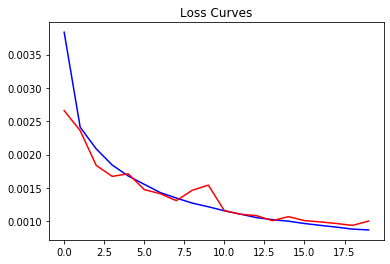

In [33]:
plt.plot(train_loss_array,'b')
plt.plot(test_loss_array,'r')
plt.title("Loss Curves");

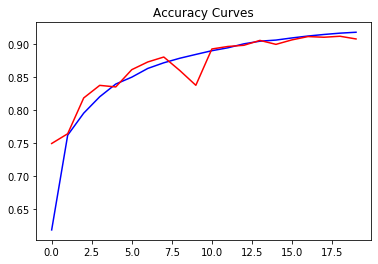

In [34]:
plt.plot(train_acc_array,'b')
plt.plot(test_acc_array,'r')
plt.title("Accuracy Curves");

**Try running for more number of epochs and see if the accuracy increases? What about Validation Accuracy?**

References:
- https://pytorch.org/tutorials/advanced/cpp_frontend.html
- https://github.com/pytorch/examples/blob/master/cpp/custom-dataset/custom-dataset.cpp